In [1]:
from utils import DecisionTreeBaggingClassifier, ipc_weighted_mse, create_new_dataset_with_ipcw_weights, calculate_ijk_variance, calculate_jk_after_bootstrap_variance, calculate_bootstrap_variance
from lifelines import KaplanMeierFitter
from sklearn.model_selection import KFold, ParameterGrid
from sksurv.util import Surv
from io import StringIO
from joblib import Parallel, delayed
import requests, os, json
import pandas as pd
import numpy as np
import gower
import matplotlib.pyplot as plt

### Datenanalyse

In [2]:
### TXREG Daten ziehen   ins df Dataframe
 
# Define the URL and credentials
url = "https://cloud.h-da.de/public.php/webdav"
username = "DNQpTLHqBQzbkFL"

with open('secret.json', 'r') as f:
    data = json.load(f)
    password = data['IDEN_DATA_SHARE_PW']

# Make the GET request with basic authentication
response = requests.get(url, auth=(username, password), headers={"X-Requested-With": "XMLHttpRequest"})

# Check if the request was successful
if response.status_code == 200:
    # Read the CSV data
    df = pd.read_csv(StringIO(response.text))
    print('Data retrieved successfully')
else:
    print(f"Failed to retrieve data: {response.status_code}")

Data retrieved successfully


In [3]:
# Gruppiere die Spalten nach ihren Datentypen
datatypes = df.dtypes

# Iteriere über jeden einzigartigen Datentyp
for dtype in datatypes.unique():
    print(f"Spalten mit Datentyp {dtype}  ({len(datatypes[datatypes == dtype].index.tolist())} Merkmale):")
    print(datatypes[datatypes == dtype].index.tolist())
    print()  # Leerzeile zur besseren Übersicht

print('Shape: ')
print(df.shape)
n_1 = df.shape[0]

Spalten mit Datentyp float64  (9 Merkmale):
['time', 'donor_age_years', 'donor_height_cm', 'donor_weight_kg', 'donor_creatinin_umol_per_l', 'recipient_age_years', 'recipient_height_cm', 'recipient_weight_kg', 'recipient_dialysis_years']

Spalten mit Datentyp int64  (3 Merkmale):
['event', 'recipient_pra', 'transplant_cold_ischemia_time_min']

Spalten mit Datentyp object  (5 Merkmale):
['donor_sex', 'donor_death_reason', 'recipient_sex', 'recipient_diagnosis', 'destination']

Spalten mit Datentyp bool  (7 Merkmale):
['donor_diabetes', 'donor_hypertension', 'donor_smoking', 'donor_hcv', 'recipient_bloodtransfusion', 'recipient_hcv', 'transplant_abo_compat']

Shape: 
(17016, 24)


In [4]:
# Zeilen entfernen mit time <= 0

df = df[df['time']>0]
print(f'{n_1-df.shape[0]} Zeilen entfernt')
print('\nShape nach time>0: ')
print(df.shape)

1230 Zeilen entfernt

Shape nach time>0: 
(15786, 24)


In [5]:
### Kategorische Merkmale mit zu vielen Ausprägungen entfernen/binarisieren

# transplant_abo_compat hat 2 ausprägungen, wovon eine nur 3 mal vorkommt --- > daher merkmal entfernen
# recipient_diagnosis   248 ausprägungen  -- merkmal rausnehmen, tipp von prof. dr. jahn
# donor_death_reason    41  ausprägungen  -- merkmal rausnehmen, tipp von prof. dr. jahn
df = df.drop(['recipient_diagnosis', 'donor_death_reason','transplant_abo_compat'], axis=1)

# recipient_pra 0 oder 1 setzen und in bool umwandeln, 0 falls 0 sonst 1, tipp von prof. dr. jahn
df['recipient_pra'] = df['recipient_pra'].apply(lambda x: x != 0)

In [6]:
# Merkmal destination, ausprägungen local dünn besetzt  --> zeilen mit der ausprägung rausnehmen
event_counts = df.groupby('destination')['event'].value_counts().unstack(fill_value=0)
#print(event_counts)
df = df[df['destination'] != 'Local']

### Hyperparamter Optimierung

In [7]:
# def evaluate_params(params, data, X_columns, tau, seed, K):
#     """
#     Evaluate a set of hyperparameters using cross-validation.
#     """
#     kf = KFold(n_splits=K, shuffle=True, random_state=seed)
#     mse_scores = []

#     for train_index, val_index in kf.split(data):
#         # Split data
#         df_train = data.iloc[train_index].reset_index(drop=True)
#         df_val = data.iloc[val_index].reset_index(drop=True)

#         # Fit Kaplan-Meier estimator on training data
#         kmf = KaplanMeierFitter()
#         kmf.fit(
#             durations=df_train["time"].astype(float),
#             event_observed=1 - df_train["event"].astype(bool),
#         )

#         # Compute IPCW weights for training and validation data
#         df_train,_,_ = create_new_dataset_with_ipcw_weights(df_train, t=tau, kmf=kmf)
#         df_val,_,_ = create_new_dataset_with_ipcw_weights(df_val, t=tau, kmf=kmf)

#         # Create dummy variables
#         df_train_dummy = pd.get_dummies(df_train, drop_first=True)
#         df_val_dummy = pd.get_dummies(df_val, drop_first=True)

#         # Ensure both datasets have the same columns
#         df_val_dummy = df_val_dummy.reindex(columns=df_train_dummy.columns, fill_value=0)

#         # Prepare features and target
#         X_train = df_train_dummy.drop(["time", "event", "weights_ipcw", "survived"], axis=1).values
#         y_train = df_train_dummy["survived"].values
#         sample_weights_train = df_train_dummy["weights_ipcw"].values

#         X_val = df_val_dummy.drop(["time", "event", "weights_ipcw", "survived"], axis=1).values
#         y_val = df_val_dummy["survived"].values
#         sample_weights_val = df_val_dummy["weights_ipcw"].values

#         # Train model
#         clf = DecisionTreeBaggingClassifier(params)
#         clf.fit(X_train, y_train, sample_weights=sample_weights_train)

#         # Predict probabilities
#         _, pred = clf.predict_proba(X_val)

#         # Compute IPCW MSE on validation data
#         rf_mse_ipcw = ipc_weighted_mse(
#             y_true=y_val,
#             y_pred=pred,
#             sample_weight=sample_weights_val,
#         )

#         mse_scores.append(rf_mse_ipcw)

#     mean_mse = np.mean(mse_scores)
#     print(f"Params: {params}, Mean IPCW MSE: {mean_mse}")

#     return mean_mse, params

# # Hyperparameter grid for tuning
# param_grid = {
#     'n_estimators': [8000],
#     'max_depth': [5,6, 7,8,9,10],
#     'min_samples_split': [10, 20, 30, 40, 50],
#     'max_features': ['sqrt','log2'],
#     'random_state': [42],
#     'weighted_bootstrapping': [True],
# }

# # Prepare data
# X_columns = df.columns.tolist()
# X_columns.remove('time')
# X_columns.remove('event')
# tau = 3 * 365
# seed = 42
# K = 10  # Number of folds
# tau = 3 * 365
# seed = 42

# data = df.copy()  # Assuming df is your original DataFrame

# # Create parameter combinations
# grid = list(ParameterGrid(param_grid))

# # Parallel computation
# results = Parallel(n_jobs=-1, verbose=10)(
#     delayed(evaluate_params)(params, data, X_columns, tau, seed, K)
#     for params in grid
# )

# # Find best parameters
# best_score = float('inf')
# best_params = None

# for mean_mse, params in results:
#     if mean_mse < best_score:
#         best_score = mean_mse
#         best_params = params

# print(f"Best Params: {best_params}, Best Mean IPCW MSE: {best_score}")

### Patienten finden für Predictions

In [8]:
### Model mit den besten Hyperparameter fitten
params_rf = {   'n_estimators':8000,                        
                'max_depth':10,
                'min_samples_split':40,
                'max_features': 'sqrt',
                'random_state':  42,
                'weighted_bootstrapping': True, }
tau = 3*365

In [9]:
# Fit Kaplan-Meier estimator on training data
kmf = KaplanMeierFitter()
kmf.fit(
    durations=df["time"].astype(float),
    event_observed=1 - df["event"].astype(bool),
)

# Compute IPCW weights for  data
df_train,_,_ = create_new_dataset_with_ipcw_weights(df, t=tau, kmf=kmf)

# Create dummy variables
df_train_dummy = pd.get_dummies(df_train, drop_first=True)

# Prepare features and target
X_train = df_train_dummy.drop(["time", "event", "weights_ipcw", "survived"], axis=1).values
y_train = df_train_dummy["survived"].values
sample_weights_train = df_train_dummy["weights_ipcw"].values

# Train model
clf = DecisionTreeBaggingClassifier(params_rf)
clf.fit(X_train, y_train, sample_weights=sample_weights_train)

# Predict probabilities
_, pred = clf.predict_proba(X_train)

# Compute IPCW MSE on validation data
rf_mse_ipcw = ipc_weighted_mse(
    y_true=y_train,
    y_pred=pred,
    sample_weight=sample_weights_train,
)

print(f"IPCW MSE: {round(rf_mse_ipcw,4)}")
print(f'Mittlere Überlebenswarscheinlichkeit: {round(pred.mean()*100,2)} %')

IPCW MSE: 0.1207
Mittlere Überlebenswarscheinlichkeit: 80.31 %


In [10]:
# finde Patienten mit niedrigster Überlebenswahrscheinlichkeit
idx_pred_min = pred.argmin()
low_patient = df.iloc[[idx_pred_min]]
low_patient_dummy_X = X_train[idx_pred_min].reshape(1,-1)
del_idx_1 = df.iloc[[idx_pred_min]].index[0]

In [11]:
# finde Patienten mit größter Überlebenswahrscheinlichkeit
idx_pred_max = pred.argmax()
high_patient = df.iloc[[idx_pred_max]]
high_patient_dummy_X = X_train[idx_pred_max].reshape(1,-1)
del_idx_2 = df.iloc[[idx_pred_max]].index[0]

In [12]:
### Find the observation closest to the average patient ###

# Exclude target variables if they are not features
target_cols = ['time', 'event']
feature_cols = df.columns.difference(target_cols)

# Step 1: Calculate mean for numerical columns (excluding target variables)
numeric_cols = df[feature_cols].select_dtypes(include=['float64', 'int64']).columns
mean_values = df[numeric_cols].mean()

# Step 2: Calculate mode for categorical columns
categorical_cols = df[feature_cols].select_dtypes(include=['object']).columns
mode_values = df[categorical_cols].mode().iloc[0]

# Step 3: Calculate mode for boolean columns
bool_cols = df[feature_cols].select_dtypes(include=['bool']).columns
bool_mode_values = df[bool_cols].mode().iloc[0]

# Step 4: Combine all results into one Series
average_patient = pd.concat([mean_values, bool_mode_values, mode_values])

# Step 5: Reindex average_patient to match feature columns
average_patient = average_patient[feature_cols]

# Step 6: Create average_patient_df with same columns as df (feature columns)
average_patient_df = pd.DataFrame([average_patient], columns=feature_cols)

# Step 7: Ensure data types match between df and average_patient_df
df_features = df[feature_cols]
average_patient_df = average_patient_df.astype(df_features.dtypes)

# Step 8: Compute Gower distances
# Note: Use only feature columns for distance calculation
distances = gower.gower_matrix(df_features, average_patient_df)

# Extract distances to the average patient
distances_to_average = distances[:, 0]

# Find the index with the minimum distance
idx_mean_patient = distances_to_average.argmin()

# Mean Patient
mean_patient = df.iloc[[idx_mean_patient]]
mean_patient_dummy_X = X_train[idx_mean_patient].reshape(1,-1)
del_idx_3 = df.iloc[[idx_mean_patient]].index[0]

In [13]:
# Diese 3 Patienten entfernen aus dem Datensatz
df = df.drop([del_idx_1,del_idx_2,del_idx_3])

### Finales Modell trainieren

In [14]:
# Fit Kaplan-Meier estimator on training data
kmf = KaplanMeierFitter()
kmf.fit(
    durations=df["time"].astype(float),
    event_observed=1 - df["event"].astype(bool),
)

# Compute IPCW weights for  data
df_train,n_events_after_cut, portion_censored_after_cut = create_new_dataset_with_ipcw_weights(df, t=tau, kmf=kmf)

# Create dummy variables
df_train_dummy = pd.get_dummies(df_train, drop_first=True)

# Prepare features and target
X_train = df_train_dummy.drop(["time", "event", "weights_ipcw", "survived"], axis=1).values
y_train = df_train_dummy["survived"].values
sample_weights_train = df_train_dummy["weights_ipcw"].values

# Train model
clf = DecisionTreeBaggingClassifier(params_rf)
clf.fit(X_train, y_train, sample_weights=sample_weights_train)

# Predict probabilities
_, pred = clf.predict_proba(X_train)

# Compute IPCW MSE on validation data
rf_mse_ipcw = ipc_weighted_mse(
    y_true=y_train,
    y_pred=pred,
    sample_weight=sample_weights_train,
)

# Merkmale zum trainieren des Classifiers festlegen
X_columns = df.columns.tolist()
X_columns.remove('time')
X_columns.remove('event')

# Gruppiere die Spalten nach ihren Datentypen
datatypes = df.dtypes

# Iteriere über jeden einzigartigen Datentyp
for dtype in datatypes.unique():
    print(f"Spalten mit Datentyp {dtype}  ({len(datatypes[datatypes == dtype].index.tolist())} Merkmale):")
    print(datatypes[datatypes == dtype].index.tolist())
    print()  # Leerzeile zur besseren Übersicht

print('Train Shape: ')
print(df.shape)

print(f'\nAnteil der Zensierten beobachtungen nach dem cut bei tau: {round(portion_censored_after_cut*100,2)}%')
print(f'Anteil der Events nach dem cut bei tau: {round(n_events_after_cut/X_train.shape[0]*100,2)}%')


Spalten mit Datentyp float64  (9 Merkmale):
['time', 'donor_age_years', 'donor_height_cm', 'donor_weight_kg', 'donor_creatinin_umol_per_l', 'recipient_age_years', 'recipient_height_cm', 'recipient_weight_kg', 'recipient_dialysis_years']

Spalten mit Datentyp int64  (2 Merkmale):
['event', 'transplant_cold_ischemia_time_min']

Spalten mit Datentyp object  (3 Merkmale):
['donor_sex', 'recipient_sex', 'destination']

Spalten mit Datentyp bool  (7 Merkmale):
['donor_diabetes', 'donor_hypertension', 'donor_smoking', 'donor_hcv', 'recipient_bloodtransfusion', 'recipient_hcv', 'recipient_pra']

Train Shape: 
(15769, 21)

Anteil der Zensierten beobachtungen nach dem cut bei tau: 19.63%
Anteil der Events nach dem cut bei tau: 18.69%


### Prediction für Patienten

In [44]:
_, pred_mean = clf.predict_proba(mean_patient_dummy_X)
_, pred_low = clf.predict_proba(low_patient_dummy_X)
_, pred_high = clf.predict_proba(high_patient_dummy_X)

print(f'Überlebenswarscheinlichkeit für Durchschnittspatienten: {round(pred_mean.mean()*100,2)} %')
print(f'Überlebenswarscheinlichkeit für geringe Überlebenswarscheinlichkeit : {round(pred_low.mean()*100,2)} %')
print(f'Überlebenswarscheinlichkeit für hohe Überlebenswarscheinlichkeit: {round(pred_high.mean()*100,2)} %')

Überlebenswarscheinlichkeit für Durchschnittspatienten: 89.44 %
Überlebenswarscheinlichkeit für geringe Überlebenswarscheinlichkeit : 40.83 %
Überlebenswarscheinlichkeit für hohe Überlebenswarscheinlichkeit: 95.03 %


### Varianz schätzung der Predictions

In [61]:
## IJK
biased_var_estimate, bias_correction = calculate_ijk_variance(clf=clf, X_pred_point=low_patient_dummy_X, df_train= df_train_dummy)
ijk_var_u_low = (biased_var_estimate - bias_correction)
ijk_var_low = biased_var_estimate
print(f'STD- IJK-U  für Patient mit low Überlebenswarscheinlichkeit: {np.round(ijk_var_u_low**0.5,4)}')

biased_var_estimate, bias_correction = calculate_ijk_variance(clf=clf, X_pred_point=mean_patient_dummy_X, df_train= df_train_dummy)
ijk_var_u_mean = (biased_var_estimate - bias_correction)
ijk_var_mean   = biased_var_estimate
print(f'STD- IJK-U für Patient mit mean Überlebenswarscheinlichkeit: {np.round(ijk_var_u_mean**0.5,4)}')

biased_var_estimate, bias_correction = calculate_ijk_variance(clf=clf, X_pred_point=high_patient_dummy_X, df_train= df_train_dummy)
ijk_var_u_high = (biased_var_estimate - bias_correction)
ijk_var_high = biased_var_estimate
print(f'STD- IJK-U für Patient mit high Überlebenswarscheinlichkeit: {np.round(ijk_var_u_high**0.5,4)}')

STD- IJK-U  für Patient mit low Überlebenswarscheinlichkeit: [0.0362]
STD- IJK-U für Patient mit mean Überlebenswarscheinlichkeit: [0.0185]
STD- IJK-U für Patient mit high Überlebenswarscheinlichkeit: [0.002]


In [47]:
## JK-AB
biased_var_estimate= calculate_jk_after_bootstrap_variance(clf=clf, X_pred_point=low_patient_dummy_X, df_train= df_train_dummy, params_rf=params_rf)
jk_var_u_low = biased_var_estimate 
print(f'STD- JK  für Patient mit low Überlebenswarscheinlichkeit: {np.round(jk_var_u_low**0.5,4)}')

biased_var_estimate = calculate_jk_after_bootstrap_variance(clf=clf, X_pred_point=mean_patient_dummy_X, df_train= df_train_dummy, params_rf=params_rf)
jk_var_u_mean = biased_var_estimate 
print(f'STD- JK für Patient mit mean Überlebenswarscheinlichkeit: {np.round(jk_var_u_mean**0.5,4)}')

biased_var_estimate= calculate_jk_after_bootstrap_variance(clf=clf, X_pred_point=high_patient_dummy_X, df_train= df_train_dummy, params_rf=params_rf)
jk_var_u_high = biased_var_estimate
print(f'STD- JK für Patient mit high Überlebenswarscheinlichkeit: {np.round(jk_var_u_high**0.5,4)}')

STD- JK  für Patient mit low Überlebenswarscheinlichkeit: 0.2054
STD- JK für Patient mit mean Überlebenswarscheinlichkeit: 0.0621
STD- JK für Patient mit high Überlebenswarscheinlichkeit: 0.0353


In [18]:
boot_var_low, boot_var_mean, boot_var_high = calculate_bootstrap_variance(df2=df, seed=42, B_first_level= 200  ,
                                                                            tau =tau, params_rf=params_rf, x_high_patient=high_patient,
                                                                            x_low_patient=low_patient, x_mean_patient=mean_patient)

print(f'STD- Boot  für Patient mit low Überlebenswarscheinlichkeit: {np.round(boot_var_low**0.5,4)}')
print(f'STD- Boot  für Patient mit mean Überlebenswarscheinlichkeit: {np.round(boot_var_mean**0.5,4)}')
print(f'STD- Boot  für Patient mit high Überlebenswarscheinlichkeit: {np.round(boot_var_high**0.5,4)}')

STD- Boot  für Patient mit low Überlebenswarscheinlichkeit: 0.0393
STD- Boot  für Patient mit mean Überlebenswarscheinlichkeit: 0.0121
STD- Boot  für Patient mit high Überlebenswarscheinlichkeit: 0.0051


In [19]:
print(f'STD- Boot  für Patient mit low Überlebenswarscheinlichkeit: {np.round(boot_var_low**0.5,4)}')
print(f'STD- Boot  für Patient mit mean Überlebenswarscheinlichkeit: {np.round(boot_var_mean**0.5,4)}')
print(f'STD- Boot  für Patient mit high Überlebenswarscheinlichkeit: {np.round(boot_var_high**0.5,4)}')

STD- Boot  für Patient mit low Überlebenswarscheinlichkeit: 0.0393
STD- Boot  für Patient mit mean Überlebenswarscheinlichkeit: 0.0121
STD- Boot  für Patient mit high Überlebenswarscheinlichkeit: 0.0051


### Plotten

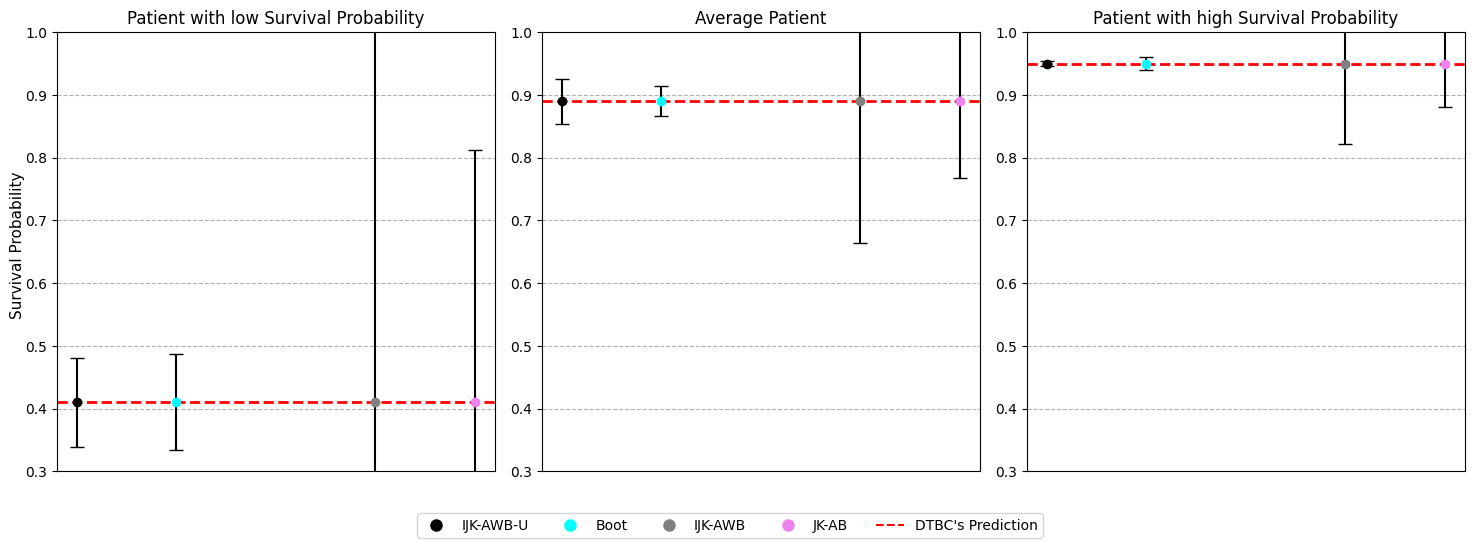

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

# Deine bestehenden Variablen und Berechnungen
boot_var_low = 0.039**2
boot_var_mean = 0.0121**2
boot_var_high = 0.0051**2

jk_var_u_low = 0.2054**2
jk_var_u_mean = 0.0621**2
jk_var_u_high = 0.0353**2

ijk_var_u_low =0.0362**2
ijk_var_u_mean =0.0185**2
ijk_var_u_high =0.002**2

ijk_var_low =   0.3794**2
ijk_var_mean =0.1156**2
ijk_var_high =0.0655**2

pred_low =40.83/100
pred_mean = 89.44/100
pred_high =95.03/100

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), sharex=False, sharey=False)

RF_Y_pred_low = round(pred_low, 2)
RF_Y_pred_mean = round(pred_mean, 2)
RF_Y_pred_high = round(pred_high, 2)

# Funktion zum Plotten, um Redundanz zu vermeiden
def plot_patient(ax, x_positions, y_pred_list, errors, title, u, a):
    colors = ['black', 'cyan', 'gray', 'violet']
    for x, y, err, color in zip(x_positions, y_pred_list, errors, colors):
        ax.errorbar(x, y, yerr=err, fmt='o', color=color, ecolor='black', capsize=5)
    ax.set_title(title)
    ax.set_ylim(u, a)
    # Zeichne eine horizontale Linie für den Mittelwert
    ax.axhline(y=y_pred_list[0], color='red', linestyle='--', linewidth=2)
    ax.grid(True, linestyle='--', alpha=1.)
    ax.set_xticks([])  # Entferne die x-Tick-Labels

# 1. Plot: Patient mit niedriger Überlebenswahrscheinlichkeit
error_ijk_low = 1.96 * np.sqrt(ijk_var_u_low)
error_jkab_low = 1.96 * np.sqrt(jk_var_u_low)
error_ijk_biased_low = 1.96 * np.sqrt(ijk_var_low)
error_boot_low = 1.96 * np.sqrt(boot_var_low)
errors_low = [error_ijk_low, error_boot_low, error_ijk_biased_low, error_jkab_low]
x_positions = [0.0, 0.25, 0.75, 1.0]
y_pred_low_list = [RF_Y_pred_low] * len(x_positions)  # Liste mit wiederholten y-Werten
plot_patient(axes[0], x_positions, y_pred_low_list, errors_low, 'Patient with low Survival Probability', 0.3, 1)

# 2. Plot: Durchschnittlicher Patient
error_ijk_mean = 1.96 * np.sqrt(ijk_var_u_mean)
error_jkab_mean = 1.96 * np.sqrt(jk_var_u_mean)
error_ijk_biased_mean = 1.96 * np.sqrt(ijk_var_mean)
error_boot_mean = 1.96 * np.sqrt(boot_var_mean)
errors_mean = [error_ijk_mean, error_boot_mean, error_ijk_biased_mean, error_jkab_mean]
y_pred_mean_list = [RF_Y_pred_mean] * len(x_positions)
plot_patient(axes[1], x_positions, y_pred_mean_list, errors_mean, 'Average Patient', 0.3, 1)

# 3. Plot: Patient mit hoher Überlebenswahrscheinlichkeit
error_ijk_high = 1.96 * np.sqrt(ijk_var_u_high)
error_jkab_high = 1.96 * np.sqrt(jk_var_u_high)
error_ijk_biased_high = 1.96 * np.sqrt(ijk_var_high)
error_boot_high = 1.96 * np.sqrt(boot_var_high)
errors_high = [error_ijk_high, error_boot_high, error_ijk_biased_high, error_jkab_high]
y_pred_high_list = [RF_Y_pred_high] * len(x_positions)
plot_patient(axes[2], x_positions, y_pred_high_list, errors_high, 'Patient with high Survival Probability', 0.3, 1)

# Gemeinsame Y-Achsenbeschriftung
fig.supylabel('Survival Probability', fontsize=11)

# Erstelle benutzerdefinierte Legenden-Handles
legend_elements = [
    Line2D([0], [0], marker='o', color='black', label='IJK-AWB-U', markersize=8, linestyle='None', markerfacecolor='black'),
    Line2D([0], [0], marker='o', color='cyan', label='Boot', markersize=8, linestyle='None', markerfacecolor='cyan'),
    Line2D([0], [0], marker='o', color='gray', label='IJK-AWB', markersize=8, linestyle='None', markerfacecolor='gray'),
    Line2D([0], [0], marker='o', color='violet', label='JK-AB', markersize=8, linestyle='None', markerfacecolor='violet'),
    Line2D([0], [0], color='red', linestyle='--', label="DTBC's Prediction")
]

# Füge die Legende zur gesamten Figur hinzu, platziere sie unten und füge einen Rahmen hinzu
fig.legend(handles=legend_elements, loc='lower center', ncol=5, frameon=True, bbox_to_anchor=(0.5, -0.1))

# Passe das Layout an, damit die Legende nicht abgeschnitten wird
plt.tight_layout()  # Erhöhe den unteren Rand, um Platz für die Legende zu schaffen
plt.show()
